<a href="https://colab.research.google.com/github/giacomoaccursi/Tirocinio/blob/main/train_with_angles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
rm -rf Tirocinio/

In [ ]:
!git clone https://github.com/giacomoaccursi/Tirocinio.git

Cloning into 'Tirocinio'...
remote: Enumerating objects: 117894, done.
remote: Counting objects: 100% (19321/19321), done.
remote: Compressing objects: 100% (19314/19314), done.
remote: Total 117894 (delta 11), reused 19317 (delta 7), pack-reused 98573
Receiving objects: 100% (117894/117894), 518.15 MiB | 25.53 MiB/s, done.
Resolving deltas: 100% (2493/2493), done.
Checking out files: 100% (45074/45074), done.


In [ ]:
import json
import numpy as np
import pandas as pd
import math

In [ ]:
from os import listdir
from os.path import isfile, join
#lista tutti i file dato un percorso
def list_all_files(input_path):
  files = [join(input_path, f) for f in listdir(input_path) if isfile(join(input_path, f))]
  return list(zip(files, listdir(input_path)))

def list_all_in_dir(input_path):
  files = [join(input_path, f) for f in listdir(input_path)]
  return files

In [ ]:
def angle_between_points( p0, p1, p2 ):
  a = (p1[0]-p0[0])**2 + (p1[1]-p0[1])**2
  b = (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2
  c = (p2[0]-p0[0])**2 + (p2[1]-p0[1])**2
  if (a == 0 or b == 0 or c == 0):
    return 0 
  return  (math.acos( (a+b-c) / math.sqrt(4*a*b) ) * 180 /math.pi)

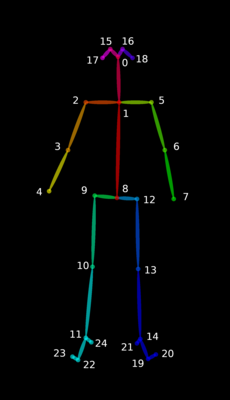

In [ ]:
angles = [
          (0, 1, 8),
          (0, 1, 2), 
          (0, 1, 5),
          (1, 2, 3),
          (2, 3, 4),
          (1, 5, 6),
          (5, 6, 7), 
          (1, 8, 9),
          (1, 8, 12), 
          (8, 9, 10), 
          (9, 12, 13), 
          (9, 10, 11), 
          (12, 13, 14), 
          (10, 11, 22), 
          (13, 14, 19)
]

In [ ]:
def calculate_angles(data):
  angle_vec = []
  for node in angles:
    coord = tuple(data[i] for i in node)
    angle_vec.append(angle_between_points(*coord))
  return angle_vec


In [ ]:
#estrae i dati dal file json
def extract_json_detection(file):
  with open(file, 'r') as f:
    data = json.load(f)
    data = data["people"][0]["pose_keypoints_2d"]
  return data

In [ ]:
def coordinate_from_data(data): 
  del data[2:75:3] 
  new_data = [ [data[i], data[i+1]] for i in range(0, len(data), 2)]
  return new_data

ad ogni frame ho le coordinate. 
creo delle triple di coordinate e poi le passo alla funzione angle_between_points()


In [ ]:
keypoints = np.arange(0, 25)
video_data = []

In [ ]:
outputs = sorted(list_all_in_dir("/content/Tirocinio/video_train_output"))
for output in outputs:
  print(output)
  files = sorted(list_all_files(output))
  vec = []
  for file in files[:100]:
    data = coordinate_from_data(extract_json_detection(file[0]))
    #vec.append(cosine_similarity_with_other_kp(data))
    vec.append(calculate_angles(data))
  video_data.append(vec)

/content/Tirocinio/video_train_output/video_01_0
/content/Tirocinio/video_train_output/video_02_0
/content/Tirocinio/video_train_output/video_03_0
/content/Tirocinio/video_train_output/video_04_0
/content/Tirocinio/video_train_output/video_05_0
/content/Tirocinio/video_train_output/video_06_0
/content/Tirocinio/video_train_output/video_07_0
/content/Tirocinio/video_train_output/video_08_0
/content/Tirocinio/video_train_output/video_09_0
/content/Tirocinio/video_train_output/video_100_1
/content/Tirocinio/video_train_output/video_101_1
/content/Tirocinio/video_train_output/video_102_1
/content/Tirocinio/video_train_output/video_103_1
/content/Tirocinio/video_train_output/video_104_1
/content/Tirocinio/video_train_output/video_105_1
/content/Tirocinio/video_train_output/video_106_1
/content/Tirocinio/video_train_output/video_107_1
/content/Tirocinio/video_train_output/video_108_1
/content/Tirocinio/video_train_output/video_109_1
/content/Tirocinio/video_train_output/video_10_0
/content/T

In [ ]:
labels = []
for output in outputs: 
  labels.append(output.split("_")[-1])

In [ ]:
labels = np.array(labels)

In [ ]:
video_data = np.array(video_data)

In [ ]:
video_data.shape

(191, 100, 15)

In [ ]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels)

In [ ]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(video_data, labels,
	test_size=0.25,stratify=labels, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Dropout

model = Sequential([
                    Conv1D(64, 5, input_shape=(X_train.shape[1], X_train.shape[2])), 
                    Flatten(), 
                    Dense(256, activation = "relu"),
                    Dropout(0.5), 
                    Dense(256, activation = "relu"), 
                    Dropout(0.5),
                    Dense(256, activation = "relu"),
                    Dropout(0.5),  
                    Dense(y_train.shape[1], activation = "softmax")
])


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=15, batch_size=20, validation_data=(X_test, y_test))

Epoch 1/15
8/8 [==============================] - 1s 52ms/step - loss: 0.6699 - accuracy: 0.6993 - val_loss: 0.1435 - val_accuracy: 0.9583
Epoch 2/15
8/8 [==============================] - 0s 31ms/step - loss: 0.3730 - accuracy: 0.8811 - val_loss: 0.2094 - val_accuracy: 0.9583
Epoch 3/15
8/8 [==============================] - 0s 26ms/step - loss: 0.1920 - accuracy: 0.9301 - val_loss: 0.2515 - val_accuracy: 0.9583
Epoch 4/15
8/8 [==============================] - 0s 25ms/step - loss: 0.2666 - accuracy: 0.9231 - val_loss: 0.1803 - val_accuracy: 0.9583
Epoch 5/15
8/8 [==============================] - 0s 25ms/step - loss: 0.1608 - accuracy: 0.9790 - val_loss: 0.2553 - val_accuracy: 0.9583
Epoch 6/15
8/8 [==============================] - 0s 25ms/step - loss: 0.0515 - accuracy: 0.9860 - val_loss: 0.3401 - val_accuracy: 0.9583
Epoch 7/15
8/8 [==============================] - 0s 24ms/step - loss: 0.0366 - accuracy: 0.9860 - val_loss: 0.4153 - val_accuracy: 0.9583
Epoch 8/15
8/8 [===========

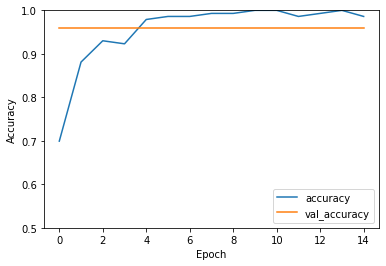

In [ ]:
import matplotlib.pyplot as plt
 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(i) for i in y_pred]
y_real = [np.argmax(i) for i in y_test]

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
confusion_matrix(y_real, y_pred)

array([[23,  0],
       [ 2, 23]])

In [ ]:
print(classification_report(y_real, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       1.00      0.92      0.96        25

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48



In [ ]:
model.predict(np.expand_dims(X_test[2], axis=0))

array([[1.0000000e+00, 1.0206235e-20]], dtype=float32)

In [ ]:
y_test[2]

array([1., 0.], dtype=float32)

In [ ]:
from keras.models import load_model
model.save('modello.h5')

In [ ]:
import json
import numpy as np
import pandas as pd

from os import listdir
from os.path import isfile, join
#lista tutti i file dato un percorso
def list_all_files(input_path):
  files = [join(input_path, f) for f in listdir(input_path) if isfile(join(input_path, f))]
  return list(zip(files, listdir(input_path)))

def list_all_in_dir(input_path):
  files = [join(input_path, f) for f in listdir(input_path)]
  return files

def angle_between_points( p0, p1, p2 ):
  a = (p1[0]-p0[0])**2 + (p1[1]-p0[1])**2
  b = (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2
  c = (p2[0]-p0[0])**2 + (p2[1]-p0[1])**2
  if (a == 0 or b == 0 or c == 0):
    return 0 
  return  (math.acos( (a+b-c) / math.sqrt(4*a*b) ) * 180 /math.pi)

#estrae i dati dal file json
def extract_json_detection(file):
  with open(file, 'r') as f:
    data = json.load(f)
    if len(data['people']) == 0: 
      return [0 for i in range(0, 75)]
    data = data["people"][0]["pose_keypoints_2d"]
  return data

angles = [
          (0, 1, 8),
          (0, 1, 2), 
          (0, 1, 5),
          (1, 2, 3),
          (2, 3, 4),
          (1, 5, 6),
          (5, 6, 7), 
          (1, 8, 9),
          (1, 8, 12), 
          (8, 9, 10), 
          (9, 12, 13), 
          (9, 10, 11), 
          (12, 13, 14), 
          (10, 11, 22), 
          (13, 14, 19)
]

def calculate_angles(data):
  angle_vec = []
  for node in angles:
    coord = tuple(data[i] for i in node)
    angle_vec.append(angle_between_points(*coord))
  return angle_vec

def coordinate_from_data(data): 
  del data[2:75:3] 
  new_data = [ [data[i], data[i+1]] for i in range(0, len(data), 2)]
  return new_data

keypoints = np.arange(0, 25)
video_data = []

outputs = sorted(list_all_in_dir("/content/Tirocinio/video_test_output"))
for output in outputs:
  #print(output)
  files = sorted(list_all_files(output))
  vec = []
  for file in files[:100]:
    data = coordinate_from_data(extract_json_detection(file[0]))
    #vec.append(cosine_similarity_with_other_kp(data))
    vec.append(calculate_angles(data))
  video_data.append(vec)



video_data = np.array(video_data)
print(len(video_data))
video_data = scaler.transform(video_data.reshape(-1, video_data.shape[-1])).reshape(video_data.shape)
predBefore = model.predict(video_data)
pred = [np.argmax(p) for p in predBefore]
[print(x, y) for x,y in zip(predBefore, pred)]





y_real = [int(out.split("_")[-1]) for out in outputs]

[print(p, r) for p,r in zip(pred,y_real)]


from sklearn.metrics import confusion_matrix, f1_score, classification_report
confusion_matrix(y_real, pred)

45
[1.00000e+00 2.42943e-16] 0
[1.0000000e+00 3.1998882e-16] 0
[1.0000000e+00 5.1437533e-15] 0
[1.0000000e+00 2.7123826e-19] 0
[1.000000e+00 8.515423e-17] 0
[1.0000000e+00 3.6514945e-13] 0
[9.9997759e-01 2.2429705e-05] 0
[1.0000000e+00 1.9672093e-09] 0
[1.000000e+00 7.708155e-10] 0
[9.999995e-01 4.319412e-07] 0
[1.0000000e+00 1.0431211e-15] 0
[1.0000000e+00 1.0311036e-12] 0
[1.00000e+00 6.81303e-18] 0
[1.00000e+00 9.83003e-12] 0
[9.9959856e-01 4.0141083e-04] 0
[1.000000e+00 9.487688e-10] 0
[1.0000000e+00 1.9909615e-15] 0
[1.0000000e+00 5.6129504e-19] 0
[1.000000e+00 2.414227e-13] 0
[1.0000000e+00 2.0750296e-10] 0
[1.0000000e+00 3.2239924e-14] 0
[9.9999976e-01 2.1779834e-07] 0
[9.9999917e-01 8.6911911e-07] 0
[1.0000000e+00 1.9455448e-16] 0
[1.0000000e+00 2.7366992e-14] 0
[1.7128104e-06 9.9999833e-01] 1
[0.02259239 0.97740763] 1
[4.3770001e-16 1.0000000e+00] 1
[3.1466489e-06 9.9999690e-01] 1
[5.5447087e-09 1.0000000e+00] 1
[2.0316902e-07 9.9999976e-01] 1
[8.538748e-04 9.991461e-01] 1
[4.

array([[25,  0],
       [ 1, 19]])

In [ ]:
print(list(zip(pred, outputs)))

[(0, '/content/Tirocinio/video_test_output/video_192_0'), (0, '/content/Tirocinio/video_test_output/video_193_0'), (0, '/content/Tirocinio/video_test_output/video_194_0'), (0, '/content/Tirocinio/video_test_output/video_195_0'), (0, '/content/Tirocinio/video_test_output/video_196_0'), (0, '/content/Tirocinio/video_test_output/video_197_0'), (0, '/content/Tirocinio/video_test_output/video_198_0'), (0, '/content/Tirocinio/video_test_output/video_199_0'), (0, '/content/Tirocinio/video_test_output/video_200_0'), (0, '/content/Tirocinio/video_test_output/video_201_0'), (0, '/content/Tirocinio/video_test_output/video_202_0'), (0, '/content/Tirocinio/video_test_output/video_203_0'), (0, '/content/Tirocinio/video_test_output/video_204_0'), (0, '/content/Tirocinio/video_test_output/video_205_0'), (0, '/content/Tirocinio/video_test_output/video_206_0'), (0, '/content/Tirocinio/video_test_output/video_207_0'), (0, '/content/Tirocinio/video_test_output/video_208_0'), (0, '/content/Tirocinio/video_

In [ ]:
files = sorted(list_all_files("/content/Tirocinio/video_test_output/video_235_1"))
video = []
for file in files[:100]:
  data = coordinate_from_data(extract_json_detection(file[0]))
  video.append(calculate_angles(data)) 
video = scaler.fit_transform(video)
model.predict(np.expand_dims(video, axis=0))

array([[1.8358203e-06, 9.9999821e-01]], dtype=float32)

In [ ]:
video = scaler.fit_transform(video)

In [ ]:
for x in sorted(list_all_in_dir("/content/Tirocinio/video_test_output/")):
  files = sorted(list_all_files(x))
  video = []
  for file in files[:100]:
    data = coordinate_from_data(extract_json_detection(file[0]))
    video.append(calculate_angles(data)) 
  video = scaler.fit_transform(video)
  print( x.split("/")[-1], " --------", model.predict(np.expand_dims(video, axis=0)))

video_192_0  -------- [[9.9999976e-01 2.5827592e-07]]
video_193_0  -------- [[1.000000e+00 1.690652e-11]]
video_194_0  -------- [[9.999999e-01 7.105820e-08]]
video_195_0  -------- [[1.000000e+00 6.003532e-13]]
video_196_0  -------- [[9.9999881e-01 1.1367414e-06]]
video_197_0  -------- [[1.000000e+00 6.830184e-09]]
video_198_0  -------- [[0.9227521  0.07724798]]
video_199_0  -------- [[9.9999988e-01 1.4924106e-07]]
video_200_0  -------- [[9.99987721e-01 1.23347745e-05]]
video_201_0  -------- [[9.9999928e-01 7.2647623e-07]]
video_202_0  -------- [[9.9999976e-01 1.9584616e-07]]
video_203_0  -------- [[1.000000e+00 2.381386e-09]]
video_204_0  -------- [[1.00000e+00 3.04641e-08]]
video_205_0  -------- [[1.0000000e+00 2.6940075e-11]]
video_206_0  -------- [[9.9983668e-01 1.6333851e-04]]
video_207_0  -------- [[1.000000e+00 8.940291e-09]]
video_208_0  -------- [[1.0000000e+00 1.5353324e-08]]
video_209_0  -------- [[1.0000000e+00 2.3093767e-10]]
video_210_0  -------- [[9.999609e-01 3.908083e-0